In [7]:
from __future__ import print_function

import argparse
import os
import shutil
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as torch_transforms
import torch.nn.functional as F

# import dataset.cifar10 as dataset
from utils import AverageMeter, accuracy, mkdir_p
from tensorboardX import SummaryWriter

from fastai.basics import *
from fastai.data.block import *
from fastai.vision import models
from fastai.vision.augment import *
from fastai.vision.core import PILImageBW
from fastai.vision.data import *
from fastai.vision.learner import create_cnn_model

from sklearn.model_selection import train_test_split

In [8]:
# Optimization options
epochs=20
start_epoch=0
batch_size=32
lr=0.002
# Checkpoints
resume=''
# Miscs
manualSeed=0
#Device options
gpu=0
#Method options
train_iteration=8
out='result'
alpha=0.75
lambda_u=75
T=0.5
ema_decay=0.999

n_out = 2
model_arq = models.resnet18

In [9]:
# Use CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
use_cuda = torch.cuda.is_available()

# Random seed
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
np.random.seed(manualSeed)

best_acc = 0  # best test accuracy

In [10]:
# from tqdm.auto import tqdm
from tqdm.notebook import tqdm

def get_one_batch(loader, loader_iter):
    try:
        return loader.one_batch()
    except AttributeError:
        try:
            return next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            return next(loader_iter)

def train(labeled_trainloader, unlabeled_trainloader, model, n_out, optimizer, ema_optimizer, criterion, epoch, use_cuda, writer, writer_prefix, step, fastai_metrics=[]):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_x = AverageMeter()
    losses_u = AverageMeter()
    ws = AverageMeter()
    end = time.time()
    writer_metrics = {
        ('time','batch_time'): batch_time,
        ('time','data_time'): data_time,
        ('losses','loss'): losses,
        ('losses','losses_x'): losses_x,
        ('losses','losses_u'): losses_u,
        ('losses','ws'): ws,
    }
    add_metrics = {}
    for metric in fastai_metrics:
        metric.reset()
        add_metrics[('add_metric', metric.name)] = metric

    labeled_train_iter = iter(labeled_trainloader)
    unlabeled_train_iter = iter(unlabeled_trainloader)

    model.train()
    pbar = tqdm(range(train_iteration), desc=f'Epoch {epoch}')
    for batch_idx in pbar:
        
        inputs_x, targets_x = get_one_batch(labeled_trainloader, labeled_train_iter)

        (inputs_u, inputs_u2), _ = get_one_batch(unlabeled_trainloader, unlabeled_train_iter)

        # measure data loading time
        data_time.update(time.time() - end)

        batch_size = inputs_x.size(0)

        # Transform label to one-hot if needed
        if len(targets_x.size()) == 1:
            targets_x = torch.zeros(batch_size, n_out).scatter_(1, targets_x.view(-1,1).long(), 1)

        if use_cuda:
            inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
            inputs_u = inputs_u.cuda()
            inputs_u2 = inputs_u2.cuda()


        with torch.no_grad():
            # compute guessed labels of unlabel samples
            outputs_u = model(inputs_u)
            outputs_u2 = model(inputs_u2)
            p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
            pt = p**(1/T)
            targets_u = pt / pt.sum(dim=1, keepdim=True)
            targets_u = targets_u.detach()

        # mixup
        all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
        all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)
        
        l = np.random.beta(alpha, alpha)

        l = max(l, 1-l)

        idx = torch.randperm(all_inputs.size(0))

        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]

        mixed_input = l * input_a + (1 - l) * input_b
        mixed_target = l * target_a + (1 - l) * target_b

        # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
        mixed_input = list(torch.split(mixed_input, batch_size))
        mixed_input = interleave(mixed_input, batch_size)

        logits = [model(mixed_input[0])]
        for input in mixed_input[1:]:
            logits.append(model(input))

        # put interleaved samples back
        logits = interleave(logits, batch_size)
        logits_x = logits[0]
        logits_u = torch.cat(logits[1:], dim=0)

        Lx, Lu, w = criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/train_iteration)

        loss = Lx + w * Lu

        # record loss
        losses.update(loss.item(), inputs_x.size(0))
        losses_x.update(Lx.item(), inputs_x.size(0))
        losses_u.update(Lu.item(), inputs_x.size(0))
        ws.update(w, inputs_x.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema_optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # store predictions on batch
        preds = logits_x.argmax(dim=-1)
        targs = targets_x.argmax(dim=-1)
        for (metric_group, metric_name), metric in add_metrics.items():
            metric.accum_values(preds, targs)

        # write on tensorboardX
        step += 1
        for (metric_group, metric_name), metric in writer_metrics.items():
            writer.add_scalar(f'{metric_group}/{writer_prefix}_{metric_name}', metric.val, step)
        for (metric_group, metric_name), metric in add_metrics.items():
            writer.add_scalar(f'{metric_group}/{writer_prefix}_{metric_name}', metric.value, step)

        # plot progress# plot progress
        bar_metrics = {}
        for (metric_group, metric_name), metric in add_metrics.items():
            bar_metrics[metric_name] = metric.value
        pbar.set_postfix(ordered_dict=bar_metrics, data_time=data_time.avg, batch_time=batch_time.avg, loss=losses.avg, loss_x=losses_x.avg, loss_u=losses_u.avg, w=ws.avg)

    return (losses.avg, losses_x.avg, losses_u.avg,)

def validate(valloader, model, criterion, epoch, use_cuda, mode, writer, writer_prefix, step, fastai_metrics=[]):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    # top5 = AverageMeter()
    writer_metrics = {
        ('time','batch_time'): batch_time,
        ('time','data_time'): data_time,
        ('losses','loss'): losses,
        ('accuracy','acc'): top1,
    }
    add_metrics = {}
    for metric in fastai_metrics:
        metric.reset()
        add_metrics[('add_metric', metric.name)] = metric

    # switch to evaluate mode
    model.eval()

    end = time.time()
    try:
        pbar = tqdm(range(len(valloader)), desc=mode)
    except TypeError:
        pbar = tqdm(range(len(valloader.train)), desc=mode)
    with torch.no_grad():
        for batch_idx in pbar:

            inputs, targets = get_one_batch(valloader, iter(valloader))

            # measure data loading time
            data_time.update(time.time() - end)

            # Transform to one dimensional if needed
            if len(targets.size()) > 1:
                targets = targets.argmax(dim=-1)

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda(non_blocking=True)
            # compute output
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1 = accuracy(outputs, targets)
            preds = outputs.argmax(dim=-1)
            for (metric_group, metric_name), metric in add_metrics.items():
                metric.accum_values(preds, targets)
            
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            # top5.update(prec5.item(), inputs.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            bar_metrics = {}
            for (metric_group, metric_name), metric in add_metrics.items():
                bar_metrics[metric_name] = metric.value
            pbar.set_postfix(ordered_dict=bar_metrics, top1=top1.avg, loss=losses.avg, data_time=data_time.avg, batch_time=batch_time.avg)

    # write on tensorboardX
    for (metric_group, metric_name), metric in writer_metrics.items():
        writer.add_scalar(f'{metric_group}/{writer_prefix}_{metric_name}', metric.val, step)
    for (metric_group, metric_name), metric in add_metrics.items():
        writer.add_scalar(f'{metric_group}/{writer_prefix}_{metric_name}', metric.value, step)

    return (losses.avg, top1.avg)

def save_checkpoint(state, is_best, checkpoint=out, filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_best.pth.tar'))

def linear_rampup(current, rampup_length=epochs):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, lambda_u * linear_rampup(epoch)

class WeightEMA(object):
    def __init__(self, model, ema_model, alpha=0.999):
        self.model = model
        self.ema_model = ema_model
        self.alpha = alpha
        self.params = list(model.state_dict().values())
        self.ema_params = list(ema_model.state_dict().values())
        self.wd = 0.02 * lr

        for param, ema_param in zip(self.params, self.ema_params):
            param.data.copy_(ema_param.data)

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for param, ema_param in zip(self.params, self.ema_params):
            if ema_param.dtype==torch.float32:
                ema_param.mul_(self.alpha)
                ema_param.add_(param * one_minus_alpha)
                # customized weight decay
                param.mul_(1 - self.wd)

def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [11]:
from torch.utils.data import Dataset
# from tqdm.auto import tqdm
from PIL import Image

def normalise(x, mean, std):
    x, mean, std = [np.array(a, np.float32) for a in (x, mean, std)]
    x -= mean
    x *= 1.0/std
    return x

def transpose(x, source='NHWC', target='NCHW'):
    return x.transpose([source.index(d) for d in target]) 

class MixMatchDataset(Dataset):
    """MixMatch dataset."""

    def __init__(self, df, root_dir, suff='', labeled=True, transform=None, size=512):
        self.df = df
        if labeled:
            self.df.iloc[:, 1] = self.df.iloc[:, 1].astype('category').cat.codes
        self.root_dir = root_dir
        self.suff = suff
        self.labeled = labeled
        self.transform = transform
        self.size = size

        self.data = []
        for idx in tqdm(range(len(df)), desc='Init images: '):
            img_name = os.path.join(self.root_dir,
                                    self.df.iloc[idx, 0] + self.suff)
            image = Image.open(img_name)
            image = torch_transforms.Resize(self.size)(image)
            image = np.array(image)
            self.data.append(image)
        self.data = np.array(self.data)

        self.data_mean = np.mean(self.data, axis=(0,1,2)) # or use ImageNet stats (dividing all by 255)
        self.data_std = np.std(self.data, axis=(0,1,2)) # or use ImageNet stats (dividing all by 255)

        self.data = normalise(self.data, self.data_mean, self.data_std)
        if len(self.data.shape) > 3:
            self.data = transpose(self.data)

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Use this if not all images can fit in-memory when __init__
        # img_name = os.path.join(self.root_dir,
        #                         self.df.iloc[idx, 0] + self.suff)
        # image = Image.open(img_name)
        # image = normalise(image, self.data_mean, self.data_std)
        # if len(image.shape) > 2:
        #     image = transpose(, source='HWC', target='CHW')

        image = self.data[idx]

        if self.transform:
            if self.labeled:
                image = self.transform(image)
                target = torch.as_tensor(self.df.iloc[idx, 1], dtype=torch.long)
            else:
                image = (self.transform(image), self.transform(image))
                target = -1

        return image, target

In [12]:
if not os.path.isdir(out):
    mkdir_p(out)

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    PATH_DRIVER = '/content/gdrive/My Drive/'
    DATA_FOLDER = 'Dataset/'
else:
    PATH_DRIVER = ''
    DATA_FOLDER = 'C:/Users/Lluis/Desktop/Machine Learning/radiology_ai/data/'

PATH_PREFIX = os.path.join(PATH_DRIVER, DATA_FOLDER, '')
raw_folder = PATH_PREFIX + 'DICOMS'
organize_folder = PATH_PREFIX + 'pending_classification'
preprocess_folder = PATH_PREFIX + 'preprocess'

df = pd.read_excel(os.path.join(PATH_PREFIX, 'all.xlsx'), dtype={'ID':'string','Target':'string'})
label_df = df[['ID','Target']][df['Target'].notnull()]
train_df, test_df = train_test_split(label_df, test_size=0.15, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.15, shuffle=True)

# Data
print(f'==> Preparing dataset')
transform_train = torch_transforms.Compose([
    torch_transforms.ToPILImage(),
    # torch_transforms.Resize(512),
    torch_transforms.RandomCrop(256),
    torch_transforms.RandomHorizontalFlip(),
    torch_transforms.ToTensor(),
])

fastai_transform_train = [
    RandomResizedCropGPU(256),
    Flip()
]

labeled_trainloader = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), MultiCategoryBlock),
    get_x=ColReader('ID', pref=preprocess_folder+'/', suff='.png'), 
    get_y=ColReader('Target'),
    splitter=RandomSplitter(0),
    item_tfms=Resize(512),
    batch_tfms=fastai_transform_train,
).dataloaders(train_df, bs=batch_size, num_workers=0, shuffle_train=True, drop_last=True)

val_loader = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), MultiCategoryBlock),
    get_x=ColReader('ID', pref=preprocess_folder+'/', suff='.png'), 
    get_y=ColReader('Target'),
    splitter=RandomSplitter(0),
    item_tfms=Resize(512),
    # batch_tfms=fastai_transform_train,
).dataloaders(val_df, bs=batch_size, num_workers=0, shuffle_train=False, drop_last=True)

test_loader = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), MultiCategoryBlock),
    get_x=ColReader('ID', pref=preprocess_folder+'/', suff='.png'), 
    get_y=ColReader('Target'),
    splitter=RandomSplitter(0),
    item_tfms=Resize(512),
    # batch_tfms=fastai_transform_train,
).dataloaders(test_df, bs=batch_size, num_workers=0, shuffle_train=False, drop_last=True)

unlabeled_trainloader = data.DataLoader(
    MixMatchDataset(df[['ID','Target']][df['Target'].isnull()], root_dir=preprocess_folder, suff='.png', labeled=False, transform=transform_train),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

# Model
print("==> creating model")

def create_model(model_arq, n_out, pretrained=True, n_in=1, ema=False):
    model = create_cnn_model(model_arq, n_out=n_out, cut=None, pretrained=pretrained, n_in=n_in)
    model = model.cuda()

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

model = create_model(model_arq, n_out, pretrained=True, n_in=1)
ema_model = create_model(model_arq, n_out, pretrained=True, n_in=1, ema=True)

cudnn.benchmark = True
print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

train_criterion = SemiLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

ema_optimizer= WeightEMA(model, ema_model, alpha=ema_decay)
start_epoch = 0

# Resume
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isfile(resume), 'Error: no checkpoint directory found!'
    out = os.path.dirname(resume)
    checkpoint = torch.load(resume)
    best_acc = checkpoint['best_acc']
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    ema_model.load_state_dict(checkpoint['ema_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

writer = SummaryWriter(out, flush_secs=10)
f1_score = F1ScoreMulti(average='macro')
precision = PrecisionMulti(average='macro')
recall = RecallMulti(average='macro')
fastai_metrics = [f1_score, precision, recall]
step = 0
test_accs = []
# Train and val
for epoch in range(start_epoch, epochs):

    train_loss, train_loss_x, train_loss_u = train(labeled_trainloader, unlabeled_trainloader, model, n_out, optimizer, ema_optimizer, train_criterion, epoch, use_cuda, writer=writer, writer_prefix='train', step=step, fastai_metrics=fastai_metrics)

    step = train_iteration * (epoch + 1)

    _, train_acc = validate(labeled_trainloader, ema_model, criterion, epoch, use_cuda, mode='Train Stats', writer=writer, writer_prefix='train_eval', step=step, fastai_metrics=fastai_metrics)
    val_loss, val_acc = validate(val_loader, ema_model, criterion, epoch, use_cuda, mode='Valid Stats', writer=writer, writer_prefix='valid', step=step, fastai_metrics=fastai_metrics)
    test_loss, test_acc = validate(test_loader, ema_model, criterion, epoch, use_cuda, mode='Test Stats', writer=writer, writer_prefix='test', step=step, fastai_metrics=fastai_metrics)

    # save model
    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'ema_state_dict': ema_model.state_dict(),
            'acc': val_acc,
            'best_acc': best_acc,
            'optimizer' : optimizer.state_dict(),
        }, is_best)
    test_accs.append(test_acc)
writer.close()

print('Best acc:')
print(best_acc)

print('Mean acc:')
print(np.mean(test_accs[-20:]))

==> Preparing dataset



==> creating model
    Total params: 11.70M


KeyboardInterrupt: 

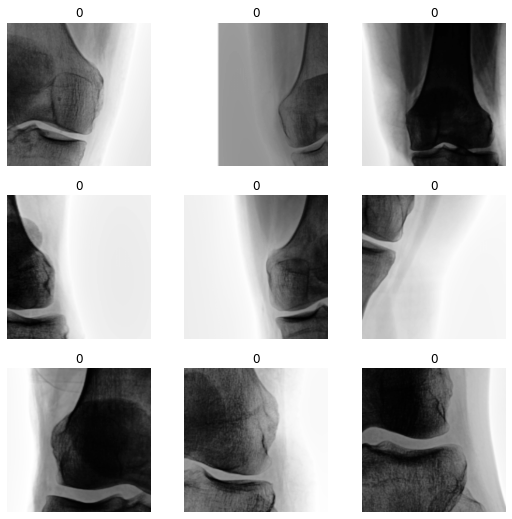

In [254]:
labeled_trainloader.show_batch()